<a href="https://colab.research.google.com/github/MuhammedAshraf2020/object_detection/blob/main/Autonomous_driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import librarys**

In [116]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

In [50]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):

    box_scores = box_confidence * box_class_probs

    box_classes = K.argmax(box_scores , axis = -1)
    box_class_scores = K.max(box_scores , axis = -1)

    filtering_mask = box_class_scores >= threshold

    scores = tf.boolean_mask(  box_class_scores , filtering_mask)
    boxes = tf.boolean_mask( boxes , filtering_mask)
    classes = tf.boolean_mask(box_classes , filtering_mask)

    return scores, boxes, classes

In [51]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width  = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area   = inter_width * inter_height if inter_width > 0 and inter_height > 0 else 0

    box1_area  = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area  = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area

    return iou

In [125]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.compat.v1.variables_initializer([max_boxes_tensor])) 
    

    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)

    scores  = K.gather(scores,  nms_indices)
    boxes   = K.gather(boxes,   nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [53]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):

    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    
    return scores, boxes, classes

In [54]:
sess = K.get_session()

In [55]:
class_names = ['person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog',
 'horse','sheep','cow','elephant', 'bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase',
 'frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa','pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse','remote','keyboard','cell phone',
 'microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush']

In [56]:
anchors = np.array([
       [ 0.57273 ,  0.677385],
       [ 1.87446 ,  2.06253 ],
       [ 3.33843 ,  5.47434 ],
       [ 7.88282 ,  3.52778 ],
       [ 9.77052 ,  9.16828 ]])

In [43]:
!wget http://pjreddie.com/media/files/yolo.weights

URL transformed to HTTPS due to an HSTS policy
--2020-12-04 22:53:35--  https://pjreddie.com/media/files/yolo.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolo.weights’

yolo.weights          0%[                    ]   1.54M   793KB/s               ^C


In [128]:
yolo_model = load_model("/content/yolo.h5")

In [129]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [140]:
image_shape = (1100., 880.)

In [141]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [142]:
def predict(sess, image_file):

    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data,
                                                                                       K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    colors = generate_colors(class_names)

    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    image.save(os.path.join("out", image_file), quality=90)

    output_image = plt.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [122]:
tf.compat.v1.disable_eager_execution()

Found 1 boxes for dog.jpg
dog 0.79 (313, 98) (765, 833)


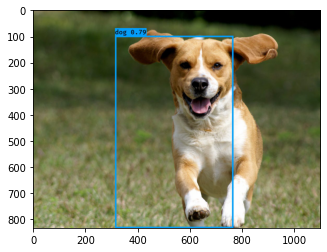

In [143]:
out_scores, out_boxes, out_classes = predict(sess, "dog.jpg")

In [134]:
!mv "/content/coursera-deeplearning-specialization/04_Convolutional_Neural_Networks/week3/Car_detection_for_Autonomous_Driving/font" "/content"

In [120]:
image, image_data = preprocess_image("dog.jpg", model_image_size = (608, 608))

In [121]:
out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data,
                                                                                       K.learning_phase(): 0})

TypeError: ignored